In [243]:
# Python 3.11
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from typing import Annotated

import graphinglib as gl # pip install git+https://github.com/GraphingLib/GraphingLib.git
import scavenger as sg # pip install csv-scavenger
from pydantic import BaseModel, validate_call, Field # pip install pydantic

# Définition des classes qui contiennent les propriétés de l'aile

In [244]:
class BaseAile(BaseModel):
    """
    Classe de base pour les ailes. Contient les méthodes et propriétés communes à toutes les parties de l'aile.
    """
    @validate_call
    def c(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        slope = (0.34 - 0.606) / 1.51
        return 0.606 + slope * position_l
    
    def surface_profile(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 0.0851101 * self.c(position_l) ** 2
    
    def perimetre_profile(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 2.0654 * self.c(position_l)


class RevAile(BaseAile):
    """
    Classe pour les propriétés du revêtement de l'aile. Hérite aussi les propriétés de BaseAile.
    """
    @property
    def epaisseur(self):
        return 0.35 * 10**(-3)

    @property
    def E(self):
        return 64e9
    
    @property
    def G_xy(self):
        return 5e9
    
    @property
    def nu_xy(self):
        return 0.047

    @property
    def c_rupture_traction_x_et_y(self):
        return 800e6
    
    @property
    def c_rupture_compression_x_et_y(self):
        return 700e6
    
    @property
    def c_rupture_cisaillement_dans_plan(self):
        return 130e6
    
    def centroide_x(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 0.49251 * self.c(position_l)

    def centroide_y(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 0.046128 * self.c(position_l)
    
    def I_x(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 0.0051752 * (self.c(position_l) ** 3) * self.epaisseur
    
    def I_y(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 0.17878 * (self.c(position_l) ** 3) * self.epaisseur
    
    def I_xy(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return -0.0010805 * (self.c(position_l) ** 3) * self.epaisseur


class CoeurAile(BaseAile):
    """
    Classe pour les propriétés du coeur de l'aile. Hérite aussi les propriétés de BaseAile.
    """
    @property
    def E(self):
        return 26e6
    
    @property
    def poisson(self):
        return 0.1
    
    @property
    def c_rupture_traction(self):
        return 500e3
    
    @property
    def limite_elasticite_compression(self):
        return 290e3
    
    @property
    def c_rupture_cisaillement_dans_plan(self):
        return 600e3
    
    def I_x(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 9.8490e-5 * (self.c(position_l) ** 4)
    
    def I_y(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 4.3219e-3 * (self.c(position_l) ** 4)
    
    def I_xy(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 8.3263e-5 * (self.c(position_l) ** 4)

    def centroide_x(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 0.40575 * self.c(position_l)
    
    def centroide_y(self, position_l: Annotated[float, Field(ge=0, le=1.51)]):
        return 0.053017 * self.c(position_l)

rev_aile = RevAile()
coeur_aile = CoeurAile()

# Load données du profil + interpolation

Valeur max de y normalisé = 0.128
Valeur min de y normalisé = -0.018


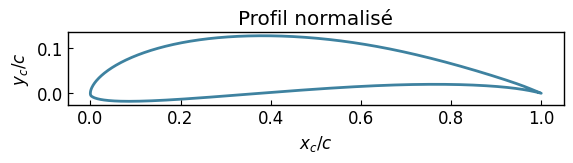

In [245]:
# Faire interpolation ou pas?
interpoler = True

# Load les données du profil
profile_full_data = sg.read_csv("profile.csv")
x_original = profile_full_data['x'].values
y_original = profile_full_data['y'].values
x_original = np.array(x_original)
y_original = np.array(y_original)


if interpoler:
    num_points = 1000

    s = np.zeros(x_original.shape) # paramétrisation 
    s[1:] = np.sqrt((x_original[1:] - x_original[:-1])**2 + (y_original[1:] - y_original[:-1])**2).cumsum()
    s_total = s[-1]
    spline_t = np.linspace(0, s_total, num_points)

    spline_x = CubicSpline(s, x_original)
    spline_y = CubicSpline(s, y_original)

    x_profile = spline_x(spline_t) # type: np.ndarray
    y_profile = spline_y(spline_t) # type: np.ndarray
else:
    x_profile = x_original # type: np.ndarray
    y_profile = y_original # type: np.ndarray

# Trouver les valeurs max et min de y
y_max_norm = max(y_profile)
y_min_norm = min(y_profile)
print(f"Valeur max de y normalisé = {y_max_norm:.3f}")
print(f"Valeur min de y normalisé = {y_min_norm:.3f}")

# Graphique du profil
curve_v = gl.Curve(x_profile, y_profile)
fig = gl.Figure(x_label=r'$x_c/c$', y_label=r'$y_c/c$', title='Profil normalisé')
fig.add_elements(curve_v)
fig._prepare_figure()
fig._axes.set_aspect('equal')
fig._figure



# Load données de chargement

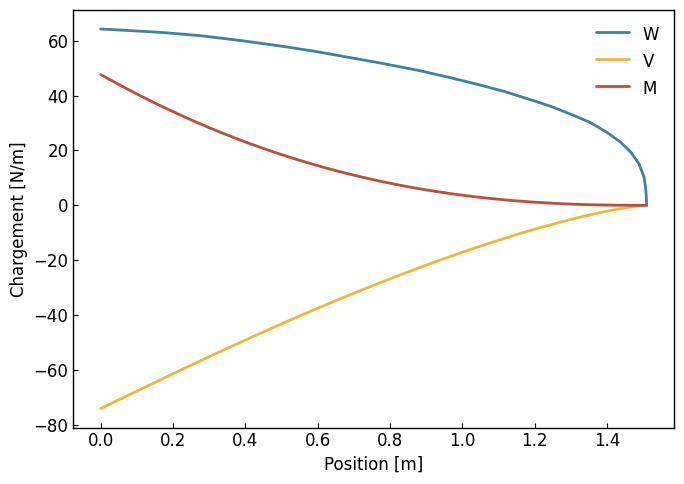

In [246]:
# Mettre à 3 pour appliquer un facteur de charge de 3, 1 sinon
facteur_de_charge = 1

# Load les données de chargement
chargement_data = sg.read_csv("lift.csv")
chargement_data.columns = ['Position', 'Chargement']

positions_aile = chargement_data['Position'].values
chargements_aile = chargement_data['Chargement'].values
positions_aile = np.array(positions_aile)
chargements_aile = np.array(chargements_aile) * facteur_de_charge

# Interpoler les données de chargement (pour avoir espacement régulier)
new_x = np.linspace(min(positions_aile), max(positions_aile), 1000)
new_y = np.interp(new_x, positions_aile, chargements_aile)
positions_aile = new_x
chargements_aile = new_y

# Créer les courbes de w, v et m
curve_w = gl.Curve(positions_aile, chargements_aile, label="W")

curve_v = curve_w.create_integral_curve()
curve_v = curve_v - max(curve_v)
curve_v.label = "V"

curve_m = curve_v.create_integral_curve()
curve_m = curve_m - min(curve_m)
curve_m.label = "M"

# Graphique
fig = gl.Figure(size=(7, 5), x_label='Position [m]', y_label='Chargement [N/m]')
fig.add_elements(curve_w, curve_v, curve_m)
plt.close()
fig.show()

# Calcul de la contrainte maximale $\sigma_{max}$

La contrainte maximale $\sigma_{max}$ est calculée pour le revêtement seulement. On utilise la formule:

$$\sigma_{max} = \frac{|M_{max}| \cdot y}{I_{x}}$$

Puisque les 3 variables changent en fonction de la position, on va calculer le produit $My/I_x$ pour chaque point le long de l'aile et trouver le maximum.

M a été calculé précédemment pour chaque point le long de l'aile.

Il reste à calculer $I_{x}$ pour chaque point le long de l'aile et
la valeur y.

### Calcul de $I_{x}$ pour le revêtement

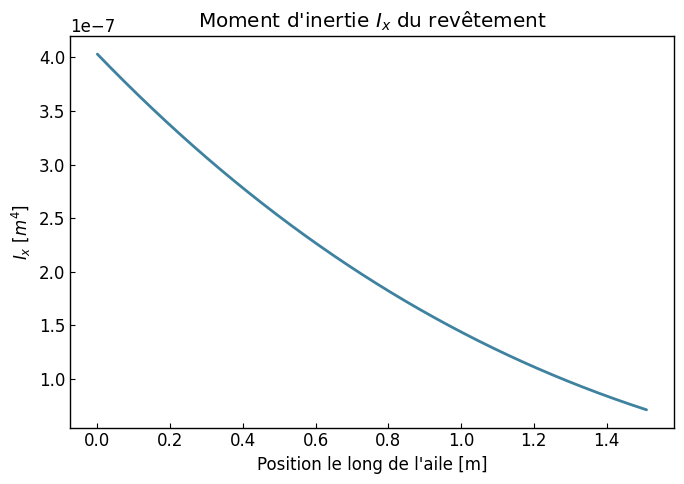

In [247]:
# Calcul des valeurs de I_x pour le revêtement
valeurs_I_x_rev = [rev_aile.I_x(l) for l in positions_aile]
curve_I_x_rev = gl.Curve(positions_aile, valeurs_I_x_rev)

# Graphique
fig = gl.Figure(size=(7, 5), x_label="Position le long de l'aile [m]", y_label='$I_x$ [$m^4$]', title="Moment d'inertie $I_x$ du revêtement")
fig.add_elements(curve_I_x_rev)
fig.show()

### Calcul des valeurs de y

Les valeurs de y sont calculées pour chaque point le long de l'aile. On utilise la formule:

$$y = y_{peak} - y_c$$

$y_c$ est la position en y du centroïde de la section de l'aile. $y_{peak}$ est l position en y du point le plus éloigné du centroïde.
Dans le code, on a $y_{max}$ et $y_{min}$, il suffit de prendre la valeur absolue de la plus grande des deux pour avoir le vrai $y_{peak}$.

On voit que les valeurs de y sont plus grandes au dessus de l'aile que en dessous. La contrainte de compression (dessus) est donc plus grande que la contrainte de traction (dessous).

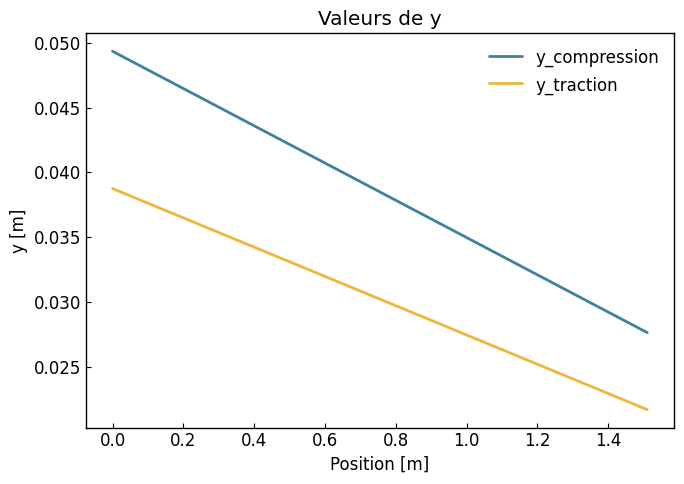

In [248]:
# Chaque liste contient les valeurs pour chaque position le long de l'aile
valeurs_c = [rev_aile.c(l) for l in positions_aile]
valeurs_y_max = [y_max_norm * c for c in valeurs_c]
valeurs_y_min = [y_min_norm * c for c in valeurs_c]
valeurs_centroide = [rev_aile.centroide_y(l) for l in positions_aile]

# Chargement est par en dessous du profil, donc compression à y_max et traction à y_min
y_compression = np.array(valeurs_y_max) - np.array(valeurs_centroide)
y_traction = np.array(valeurs_centroide) - np.array(valeurs_y_min)

curve_comp = gl.Curve(positions_aile, y_compression, label="y_compression")
curve_trac = gl.Curve(positions_aile, y_traction, label="y_traction")

fig = gl.Figure(size=(7, 5), x_label='Position [m]', y_label='y [m]', title='Valeurs de y')
fig.add_elements(curve_comp, curve_trac)
fig.show()


### Calcul de $\sigma_{max}$

On a toutes les valeurs nécessaires pour calculer $\sigma_{max}$ pour chaque point le long de l'aile. On trouve ensuite le maximum de ces valeurs pour avoir la contrainte maximale.

Valeur max de contrainte en compression = 5.83 MPa
Facteur de sécurité = 120.11
Valeur max de contrainte en traction = 4.58 MPa
Facteur de sécurité = 174.68


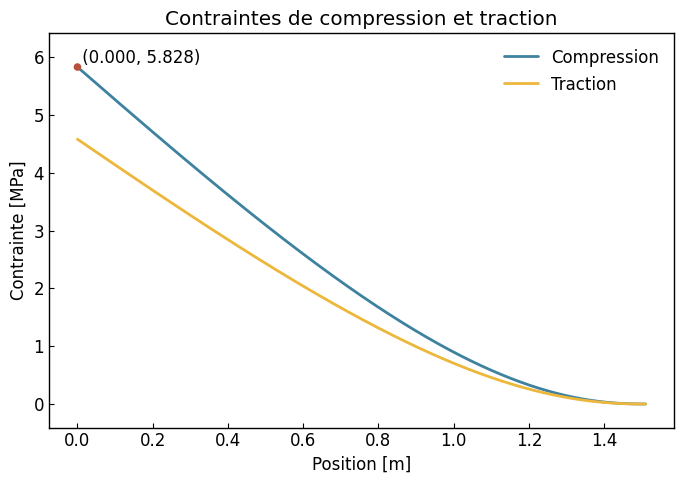

In [249]:
# Calcul des contraintes en compression
sigma_comp = curve_comp * curve_m / (curve_I_x_rev * 1e6)  # en MPa
sigma_comp.label = "Compression"

# Calcul des contraintes en traction
sigma_traction = curve_trac * curve_m / (curve_I_x_rev * 1e6) # en MPa
sigma_traction.label = "Traction"

# Trouver point max
max_comp = max(sigma_comp)
point_max_comp = sigma_comp.create_points_at_y(max_comp)[0]
point_max_comp.add_coordinates()
point_max_comp.color = 'C2'

# Calcul du facteur de sécurité pour la compression
facteur_securite = rev_aile.c_rupture_compression_x_et_y * 1e-6/ max_comp
print(f"Valeur max de contrainte en compression = {max_comp:.2f} MPa")
print(f"Facteur de sécurité = {facteur_securite:.2f}")

# Calcul du facteur de sécurité pour la traction (pas utile parce que les contraintes sont moins élevées)
max_traction = max(sigma_traction)
facteur_securite_traction = rev_aile.c_rupture_traction_x_et_y * 1e-6 / max_traction
print(f"Valeur max de contrainte en traction = {max_traction:.2f} MPa")
print(f"Facteur de sécurité = {facteur_securite_traction:.2f}")

# Graphique
figgy = gl.Figure(size=(7, 5),
                  x_label='Position [m]',
                  y_label='Contrainte [MPa]',
                  y_lim=(-0.07 * max_comp, 1.1 * max_comp),
                  title='Contraintes de compression et traction',
                  )
figgy.add_elements(sigma_comp, sigma_traction, point_max_comp)
figgy.show()

# Calcul de la contrainte de cisailement $\tau_{max}$

La contrainte de cisailement $\tau_{max}$ est calculée pour le coeur seulement. On utilise la formule:

$$\tau_{max} = \frac{V_{max} \cdot Q}{I_{x} \cdot t}$$

Puisque les variables changent en fonction de la position, on va calculer le produit $VQ/I_xt$ pour chaque point le long de l'aile et trouver le maximum.
On sait que $\tau$ est maximale à l'axe neutre. On va donc calculer les variables à cet endroit. On a déjà calculé $V$ pour chaque point le long de l'aile. Il reste à calculer $Q$, $t$, et $I_{x}$ (nouvelle courbe pour le coeur).

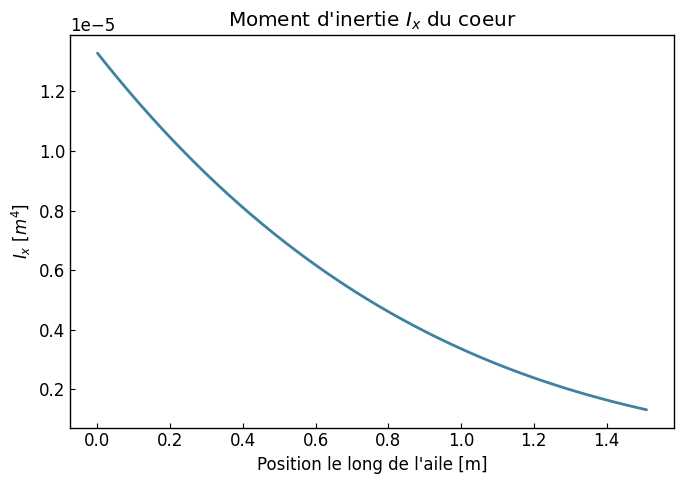

In [250]:
valeurs_I_x_coeur = [coeur_aile.I_x(l) for l in positions_aile]
curve_I_x_coeur = gl.Curve(positions_aile, valeurs_I_x_coeur)

# Graphique
fig = gl.Figure(size=(7, 5), x_label="Position le long de l'aile [m]", y_label='$I_x$ [$m^4$]', title="Moment d'inertie $I_x$ du coeur")
fig.add_elements(curve_I_x_coeur)
fig.show()

### Calcul de Q

Q est calculé pour chaque point le long de l'aile. On utilise la formule:

$$Q = \bar{y}' \cdot A'$$

$A'$ est l'aire de la partie de la section de l'aile qui est au dessus de l'axe neutre. $\bar{y}'$ est la distance entre l'axe neutre et le centroïde de cette partie de la section de l'aile.


Calcul de A' et $\bar{y}$'

In [251]:
# Créer une nouvelle courbe du profile normalisé mais en gardant seulement les valeurs au dessus du centroide du coeur
y_centroide_coeur = 0.053017
mask = y_profile >= y_centroide_coeur
y_profile_masked = y_profile[mask]
x_profile_masked = x_profile[mask]
# réordonner les valeurs en ordre croissant de x
x_profile_masked, y_profile_masked = zip(*sorted(zip(x_profile_masked, y_profile_masked)))
curve_profile_masked = gl.Curve(x_profile_masked, y_profile_masked)

# Rapporter à zéro pour faciliter le calcul de l'aire/centroide
shift = y_centroide_coeur
curve_masked_shifted = curve_profile_masked - shift


def trapezoidal_rule(x, y):
    """Calculate the area under the curve using the trapezoidal rule."""
    area = np.trapz(y, x)
    return area

def centroid_coordinates(x, y):
    """Estimate the centroid of the shape formed by the curve and the x-axis."""
    area = trapezoidal_rule(x, y)
    
    # Estimating x coordinate of the centroid
    x_centroid = np.trapz(x*y, x) / area
    
    # Estimating y coordinate of the centroid
    y_centroid = np.trapz(y**2, x) / (2*area)
    
    return x_centroid, y_centroid, area

x_centroid, y_centroid, area = centroid_coordinates(curve_masked_shifted.x_data, curve_masked_shifted.y_data)
y_centroid += shift # remettre les valeurs à leur place d'origine
point_centroid = gl.Point(x_centroid, y_centroid)
point_centroid.add_coordinates()

print(f"Valeur de A' = {area:.6f} m^2")
print(f"Valeur de y' = {y_centroid:.6f} m")

Valeur de A' = 0.040727 m^2
Valeur de y' = 0.083122 m


Calcul de t (largeur du profil à la hauteur de l'axe neutre)

In [252]:
largeur_norm = x_profile_masked[-1] - x_profile_masked[0]

ligne_t = gl.Line((x_profile_masked[0], y_profile_masked[0]), (x_profile_masked[-1], y_profile_masked[0]), capped_line=True)
text_t = gl.Text((x_profile_masked[0] + x_profile_masked[-1])/2, y_profile_masked[0] + 0.003, f"t = {largeur_norm:.4f} m")


# Calcul de t pour chaque position le long de l'aile (le t ci-dessus est pour l'aile normalisée)
valeurs_t = [largeur_norm * c for c in valeurs_c]
curve_t = gl.Curve(positions_aile, valeurs_t, label="t")

print(f"t = {largeur_norm:.4f} m")


t = 0.8015 m


Calcul de $Q$

In [253]:
# Aires et centroïdes pour chaque position le long de l'aile (les valeurs précédentes étaient pour un profil normalisé)
valeurs_aires = np.array([area * (c**2) for c in valeurs_c])
y_prime_barre = y_centroid - shift
valeurs_y_prime_barre = np.array([y_prime_barre * c for c in valeurs_c])

# Q = A' * y'_barre
valeurs_q = valeurs_aires * valeurs_y_prime_barre
curve_q = gl.Curve(positions_aile, valeurs_q, label="q")

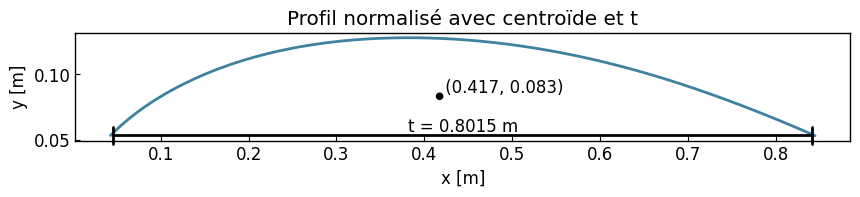

In [254]:
# Graphique profil normalisé avec centroide et t
fig = gl.Figure(x_label='x [m]', y_label='y [m]', size=(10, 5), title='Profil normalisé avec centroïde et t')
fig.add_elements(curve_profile_masked, point_centroid, ligne_t, text_t)
fig._prepare_figure()
fig._axes.set_aspect(1.5)
fig._figure

Calcul de $\tau_{max}$: on a toutes les valeurs nécessaires pour calculer $\tau_{max}$ pour chaque point le long de l'aile. On trouve ensuite le maximum de ces valeurs pour avoir la contrainte maximale.

Valeur max de tau = 3.13 kPa
Facteur de sécurité = 191.62


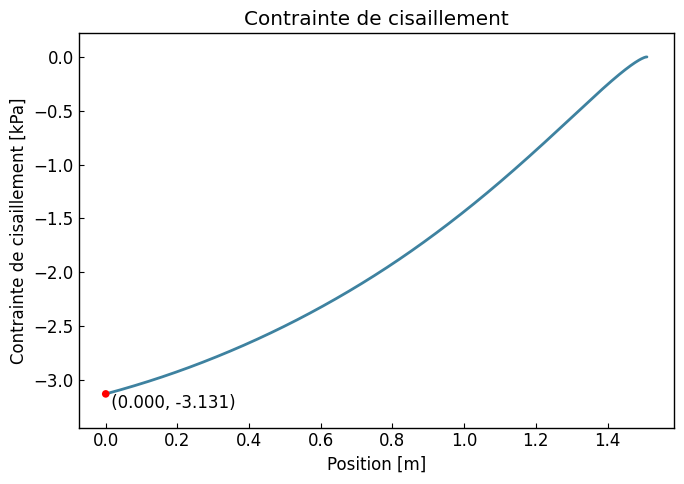

In [255]:
curve_tau = curve_q * curve_v / (curve_t * curve_I_x_coeur * 1e3)  # en kPa

# Calcul du maximum de tau absolu et du facteur de sécurité
point_max_tau = curve_tau.create_point_at_x(0)
point_max_tau.add_coordinates()
point_max_tau.color = 'red'
point_max_tau.v_align = 'top'
max_tau = abs(point_max_tau.y)


facteur_securite_tau = coeur_aile.c_rupture_cisaillement_dans_plan * 1e-3 / max_tau
print(f"Valeur max de tau = {max_tau:.2f} kPa")
print(f"Facteur de sécurité = {facteur_securite_tau:.2f}")

# Graphique
fig = gl.Figure(size=(7, 5),
                x_label='Position [m]',
                y_label='Contrainte de cisaillement [kPa]',
                title='Contrainte de cisaillement',
                y_lim=(-1.1 * max_tau, 0.07 * max_tau),
)
fig.add_elements(curve_tau, point_max_tau)
plt.close()
fig.show()

